# Negative sampling

You may have noticed that word2vec is really slow to train. Especially with big (> 50 000) vocabularies. Negative sampling is the solution.

The task is to implement word2vec with negative sampling. In more detail: you should implement two ways of negative sampling.

## Vanilla negative sampling

This is what was discussed in Stanford lecture. The main idea is in the formula:

$$ L = \log\sigma(u^T_o u_c) + \sum^k_{i=1} \mathbb{E}_{j \sim P(w)}[\log\sigma(-u^T_j, u_c)]$$

Where $\sigma$ - sigmoid function, $u_c$ - central word vector, $u_o$ - context (outside of the window) word vector, $u_j$ - vector or word with index $j$.

The first term calculates the similarity between positive examples (word from one window)

The second term is responsible for negative samples. $k$ is a hyperparameter - the number of negatives to sample.
$\mathbb{E}_{j \sim P(w)}$
means that $j$ is distributed accordingly to unigram distribution, but it is better to use $P^{3/4}(w)$ (empirical results) and you can experiment with some other approaches (for example, try to use uniform distribution).

Thus, it is only required to calculate the similarity between positive samples and some other negatives. Not across all the vocabulary.

Useful links:
1. [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
1. [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

## Batch-transpose trick for negative sampling

But we can do better. Maybe we don't need to compute vectors for negative samples at all, because we already have a batch of training data and (hopefully) examples in the batch are highly decorrelated.

Let's assume we work with Skip-gram model.

Let $S$ be a batch of _L2-normalized_ word vectors `(batch_size, 2*window_size + 1, word_vector_dim)`.

```python
x = 0.0
for batch_idx in range(batch):
    w = S[batch_idx, :, :]
    x += np.sum(w.T @ w - 1.)

y = 0.0
for window_idx in range(window):
    b = S[:, window_idx, :]
    y += np.sum(b.T @ b)

loss = -x + y```

Think about this loss and compare it to vanilla negative sampling.

Implement word2vec with batch-transpose trick. Modify the formula, if needed.

If you are interested: [more info](https://www.tensorflow.org/extras/candidate_sampling.pdf) on other methods of candidate sampling.

**Results of this task** are the very same as in task 3, **plus**:
 * implement two models (one with vanilla negative sampling and the other with batch-transpose trick)
 * compare all of the models from tasks 3-5. In terms of time and number of iterations until convergence and the quality of the resulting vectors.
 * answer the questions

### Questions:
1. Explain the batch-transpose trick formula in your own words. How would you name x, y, w and b?
1. Should it be modified to serve as a word2vec loss? If yes, how?
1. Is it possible to do the same trick with CBOW model? If yes, how?
1. Does it matter how the batch is made in the case of batch-transpose trick? In the case of vanilla negative sampling?




## Answers:
  1. _
  1. _
  1. _
  1. _

In [1]:
from pathlib import Path
from collections import Counter
from itertools import islice, product, chain
from argparse import Namespace

from tqdm import tqdm_notebook

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tensorboardX import SummaryWriter
from annoy import AnnoyIndex

from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE
from umap import UMAP
from adjustText import adjust_text

In [2]:
DATA_PATH = Path('../data')
MODELS_PATH = Path('../models')

This is an implementation of Skip-Gram with vanilla negative sampling, and update all vectors from the same window simultaneously, so all pairs center-context from the same window are in the same batch. This implementation uses PyTorch layers and custom computations.

### Preparing for training

**Creating the batcher**  
Features:
- Output values are PyTorch tensors, which contain data and labels (without negative samples)
- Negative samples will be generated in classifier, because generating negative samples are not dependent from data, and it was simpler and has better speed (in my implementation) to augment data with negative data on the classification stage
- Batcher is almost the same comparing with tasks 3-4, but has several differences:
    - Element of batch is window, not pair center-context
    - Shuffle is used for generating less correlated windows in the same batch
    - Negative sampling probabilities are calculated, for using in later stage

In [3]:
class SkipGramBatcher():
    def __init__(self, text):
        self.text = text
    
    @classmethod
    def from_file(cls, file_path):
        with open(file_path) as f:
            text = f.read()
        
        return cls(text)
    
    def _tokenize(self):
        self.tokens = self.text.split()
    
    def _count_tokens(self):
        self.token_counts = Counter(self.tokens)
    
    def _build_vocab(self, cutoff):
        self.token_counts = dict(filter(lambda x: x[1] >= cutoff, self.token_counts.items()))
        self.token_to_idx = {token:idx for (idx, (token, _)) 
                             in enumerate(self.token_counts.items())}
        self.idx_to_token = {idx:token for (token, idx) in self.token_to_idx.items()}
        self.vocab = set(self.token_to_idx)
        self.vocab_size = len(self.vocab)

    def _filter_tokens(self):
        self.tokens = [token for token in self.tokens if token in self.vocab]
        self.tokens_size = len(self.tokens)
    
    def _vectorize_tokens(self):
        self.vectorized_tokens = [self.token_to_idx[token] for token in self.tokens]
        

    def _create_sliding_window(self, window_size):
        tokens_idx = list(range(window_size, self.tokens_size - window_size))
        np.random.shuffle(tokens_idx)
                      
        for i in tokens_idx: 
#         for i in range(window_size, self.tokens_size - window_size):
            window = self.vectorized_tokens[i - window_size: i + window_size + 1]
            yield window
    
    def devectorize_tokens(self, indices):
        return [self.idx_to_token[idx] for idx in indices]
        
    def prepare_data(self, cutoff=1):
        self._tokenize()
        self._count_tokens()
        self._build_vocab(cutoff)
        self._filter_tokens()
        self._vectorize_tokens()
        
    def generate_batches(self, window_size=1, batch_size=1, drop_last=True):
        window = self._create_sliding_window(window_size)
        batch = list(islice(window, batch_size))
    
        if drop_last:
            while batch and len(batch) == batch_size:
                batch = torch.tensor(batch)
                yield batch
                batch = list(islice(window, batch_size))
        else:
            while batch:
                batch = torch.tensor(batch)
                yield batch
                batch = list(islice(window, batch_size))

In [4]:
sg_batcher = SkipGramBatcher.from_file(DATA_PATH/'text8')
sg_batcher.prepare_data(cutoff=10)

In [5]:
w = sg_batcher._create_sliding_window(3)

In [6]:
next(w)

[40, 2707, 32, 229, 63, 3426, 28]

In [7]:
g = sg_batcher.generate_batches(window_size=1, batch_size=2)

In [8]:
next(g)

tensor([[  46,  344, 3335],
        [  23,    8,   25]])

```python
x = 0.0
for batch_idx in range(batch):
    w = S[batch_idx, :, :]
    x += np.sum(w @ w.T) - 1.

y = 0.0
for window_idx in range(window):
    b = S[:, window_idx, :]
    y += np.sum(b @ b.T)

loss = -x + y```

In [9]:
class NaiveWord2VecClassifier(nn.Module):
    def __init__(self, vocabulary_size, embedding_size, neg_count=3):
        super().__init__()
        self.neg_count = neg_count
#         self.embedding = nn.Embedding(num_embeddings=vocabulary_size,
#                                       embedding_dim=embedding_size)
        self.embedding = nn.utils.weight_norm(nn.Embedding(num_embeddings=vocabulary_size,
                                      embedding_dim=embedding_size), dim=1)
        
    def forward(self, x_in):
        # emb(b, 2*w + 1) = (b, 2*w + 1, d)
        W = self.embedding(x_in)        
#         W_norm = torch.norm(W, dim=2, keepdim=True)
#         W = W / W_norm
        
        center_idx = (W.shape[1] // 2)
        
        # (b, d)
        center_words = W[:, center_idx, :]
        
        # (b, 1, d)
        center_words = center_words.unsqueeze(1)
        
        # (2*w + 1, )
        context_mask = torch.ones(W.shape[1])
        context_mask = context_mask.type(torch.ByteTensor)
        context_mask[center_idx] = 0
        
        # (b, 2*w, d)
        pos_contexts = W[:, context_mask, :]
        
        # (b, 1, 2*w)
        pos_dots = torch.bmm(center_words, pos_contexts.transpose(1, 2))
        
        # (b, d)
        neg_contexts = W[:, center_idx, :]
        
        # (b, k)
        neg_idx = torch.randint(neg_contexts.shape[0], size = (W.shape[0], self.neg_count))
        
        # (b, k, d)
        neg_samples = neg_contexts[neg_idx]
        
        # (b, 1, k)
        neg_dots = torch.bmm(center_words, neg_samples.transpose(1, 2))
        
        x_out = pos_dots
        y_out = neg_dots
        
        return x_out, y_out

In [10]:
x_in = next(g)
x_in

tensor([[ 233, 5711,   19],
        [ 244,   19,  302]])

In [11]:
clf = NaiveWord2VecClassifier(sg_batcher.vocab_size, 100)
clf(x_in)

(tensor([[[-5.1999,  5.4547]],
 
         [[15.5534, 18.8397]]], grad_fn=<BmmBackward>),
 tensor([[[ 5.4547, 84.2238,  5.4547]],
 
         [[93.6690,  5.4547, 93.6690]]], grad_fn=<BmmBackward>))

In [12]:
res = clf(x_in)
res

(tensor([[[-5.1999,  5.4547]],
 
         [[15.5534, 18.8397]]], grad_fn=<BmmBackward>),
 tensor([[[84.2238,  5.4547,  5.4547]],
 
         [[93.6690, 93.6690,  5.4547]]], grad_fn=<BmmBackward>))

Setting all possible random states to fixed number

In [13]:
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

Create namespace with all parameters for training (specified values were used for the final model)

In [14]:
args = Namespace(
    file_path = DATA_PATH/'text8',
    model_state_path = MODELS_PATH/'naive_word2vec_embeddings.pth',
    weights_path = MODELS_PATH/'weights.npz',
    
    embedding_size = 100,
    cutoff = 10,
    window_size = 3,
    neg_count = 5,
    
    seed = 42,
    
    num_epochs = 3,
    batch_size = 1024,
    learning_rate = 0.03,
    iterations = 1000,
    save_iterations = 1e8,
    early_stopping_criteria = 1e8,
    factor=0.5,
    patience=5000,
    
    cuda=True
)

Create functions for creating and updating necessary parameters while training

In [15]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': [], 
            'epoch_idx': 0,
            'batch_idx': 0,
            'loss': [],
            'model_file_name': args.model_state_path}

def update_train_state(args, model, train_state):
    if train_state['batch_idx'] == 0:
        train_state['stop_early'] = False
        torch.save(model.state_dict(), train_state['model_file_name'])
    else:
        loss = train_state['loss'][-1]

        if loss < train_state['early_stopping_best_val']:
            train_state['early_stopping_best_val'] = loss
            train_state['early_stopping_step'] = 0
            
            if train_state['batch_idx'] % args.save_iterations == 0:
                torch.save(model.state_dict(), train_state['model_file_name'])
        else:
            train_state['early_stopping_step'] += 1 
    
        train_state['stop_early'] = train_state['early_stopping_step'] >= args.early_stopping_criteria
    return train_state

Check if we can use GPU or CPU
- GPU was used to train NN, now CUDA is false for saving resources

In [16]:
if not torch.cuda.is_available():
    args.cuda=False
    
print(f'Using CUDA: {args.cuda}')
args.device = torch.device('cuda' if args.cuda else 'cpu')

Using CUDA: True


Create batcher, prepare data, and calculate vocabulary size
- All tokens with frequency less than cuttoff were removed from vocabulary and text, for this implementation cutoff=10 to have vocabulary with size about 50000 tokens
- Get probabilites for negative sampling, for using during classification stage

In [17]:
sg_batcher = SkipGramBatcher.from_file(args.file_path)
sg_batcher.prepare_data(cutoff=args.cutoff)

vocabulary_size = len(sg_batcher.vocab)
vocabulary_size

47134

### Main Training Cycle

- Only one epoch is used because of enough dataset size for training
- Learning rate scheduler is used to decrease learning rate while loss is not decreasing for specific number of iterations (was not used)
- Monitoring training progress using tqdm_notebook (not displayed because of restarting notebook after training and saving all necessary information to files)
- Tracking train state for using early stopping and saving intermediate models in file (early stopping is not used in final model)
- Cumulative moving average is used for tracking loss 

There are about 16.5 millions tokens in preprocessed text, so with window_size=3 and vocabulary=47134 there are about 99 millions pairs are used in training (1 epoch)  
Total training time is about 14 minutes on GPU P4 on Google Cloud Platform (about 19 batches per second with batch_size=1024 windows)

In [18]:
set_seeds(args.seed)

classifier = NaiveWord2VecClassifier(vocabulary_size=vocabulary_size,
                                     embedding_size=args.embedding_size,
                                     neg_count=args.neg_count)
classifier = classifier.to(args.device)

optimizer = optim.Adam(params=classifier.parameters(),
                      lr=args.learning_rate)

epoch_size = (len(sg_batcher.tokens) - (2 * args.window_size)) // args.batch_size

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min',
                                                 factor=args.factor,
                                                 patience=args.patience)

epoch_bar = tqdm_notebook(desc='Epochs', 
                          total=args.num_epochs,
                          position=1)

train_bar = tqdm_notebook(desc='Training',
                          position=1,
                          total=epoch_size)


train_state = make_train_state(args)

writer = SummaryWriter(log_dir='logs/task_5', comment='embedding_training')

running_loss = 0.
classifier.train()
iter_idx = 1

try:
    for epoch_index in range(1, args.num_epochs + 1):
        train_state['epoch_index'] = epoch_index
        
        batch_generator = sg_batcher.generate_batches(window_size=args.window_size, 
                                                      batch_size=args.batch_size)

        for batch_idx, batch in enumerate(batch_generator, 1):
            batch = batch.to(args.device)

            optimizer.zero_grad()

            x_out, y_out = classifier(x_in=batch)

    #         loss = -torch.sum(F.logsigmoid(y_out[:, :, 0])) - torch.sum(F.logsigmoid(-y_out[:, :, 1:]))
#             loss = -x_out + y_out
    #         loss = -F.logsigmoid(x_out) - F.logsigmoid(-y_out)
            loss = -torch.sum(F.logsigmoid(x_out)) - torch.sum(F.logsigmoid(-y_out))

            loss = loss / args.batch_size
            loss_value = loss.item()
            running_loss += (loss_value - running_loss) / (iter_idx)
            loss.backward()

            learning_rate = optimizer.param_groups[0]['lr']

            train_state['batch_idx'] = batch_idx
            train_state['loss'].append(running_loss)
            train_state['learning_rate'].append(learning_rate)

            train_state = update_train_state(args=args,
                                             model=classifier,
                                             train_state=train_state)

            train_params = dict(loss=running_loss,
                                lr=learning_rate,
                                early_step=train_state['early_stopping_step'],
                                early_best=train_state['early_stopping_best_val'])
            train_bar.set_postfix(train_params)
            train_bar.update()

            optimizer.step()
            scheduler.step(train_state['loss'][-1])
            
            iter_idx += 1

            if train_state['stop_early']:
                break
        
        train_bar.n = 0
        epoch_bar.update()
        
    torch.save(classifier.state_dict(), str(train_state['model_file_name']) + '_last')
except KeyboardInterrupt:
    print('Exit training')

### Visualizing of the training process results

Loss values

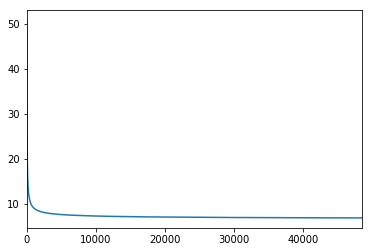

In [19]:
train_state_df = pd.DataFrame(train_state)
train_state_df['loss'].plot()
plt.show()

Learning rate values

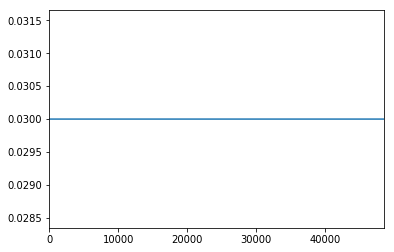

In [20]:
train_state_df['learning_rate'].plot()
plt.show()

Get matrices with word vectors, calculate average matrix, and save all theses matrices to file  
(Commented because it was used right after training)

In [21]:
W = classifier.embedding.weight.detach().cpu().numpy()
# W_prime = classifier.emb_o.weight.detach().cpu().numpy()

# W_avg = (W + W_prime) / 2
# np.savez(args.weights_path, W=W, W_prime=W_prime, W_avg=W_avg)
np.savez(args.weights_path, W=W)

Preparing words for visualizing and intrinsic evaluation (word analogies and closest vectors)

In [22]:
words = []
words.extend(['man', 'he', 'woman', 'she'])
words.extend(['fly', 'plane', 'aircraft', 'sail', 'ship', 'ships', 'circle'])
words.extend(['kitten', 'cat', 'puppy', 'dog'])
words.extend(['leg', 'legs', 'hand', 'hands'])
words.extend(['blue', 'color', 'dog', 'breed'])
words.extend(['toe', 'finger', 'foot', 'hand', 'arm'])
words.extend(['talk', 'communicate', 'read', 'interpret'])
words.extend(['man', 'king', 'woman', 'queen', 'doctor'])
words.extend(['man', 'doctor', 'woman', 'nurse'])
words.extend(['fast', 'fastest', 'small', 'smallest', 'rich', 'richest', 'faster', 'stronger'])
words = list(set(words))

### Visualizing word vectors

Load saved weights for exploring final word vectors

In [46]:
metadata = list(sg_batcher.token_to_idx)

writer = SummaryWriter(log_dir='logs/task_5_2', comment='embedding_training')
writer.add_embedding(W, metadata=metadata, tag='W')

We can now visualize words cloud in TensorBoard using PCA or TSNE

<img src="images/task_5/1.PNG" style="height:480px width:640px">

<img src="images/task_5/2.PNG" style="height:480px width:640px">

<img src="images/task_5/3.PNG" style="height:480px width:640px">

<img src="images/task_5/4.PNG" style="height:480px width:640px">

<img src="images/task_5/5.PNG" style="height:480px width:640px">

**Conclusion**
- It seems that word cloud have more homogeneous structures comparing to tasks 3-4 (the reason can't be defined exactly why because we use several new methods for training - negative sampling, shuffling, batch with window elements etc)

Let's check values in all 3 matrices using heatmaps

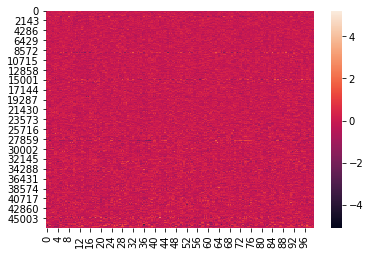

In [23]:
sns.heatmap(W)
plt.show()

**Conclusion**
- Matrices have some patterns by dimensions (vertical lines)
- Scale of the values in 2 original matrices have closer values scale comparing to task 3

Create function to plot word vectors after dimensionality reduction with auto-adjusting of label positions 

In [24]:
def plot_embeddings(embs_reduced, token_to_idx, tokens, fig_size=(12, 12)):
    token_embs = embs_reduced[[token_to_idx[token] for token in tokens]]
    
    fig, ax = plt.subplots(figsize=fig_size)
    ax.scatter(token_embs[:, 0], token_embs[:, 1], alpha=0.3)
    
    texts = [plt.text(token_embs[i, 0], token_embs[i, 1], f'{token}') for i, token in enumerate(tokens)]
    adjust_text(texts)

Apply PCA and visualize results

In [25]:
%%time
pca = PCA(n_components=2, random_state=42)
embs_pca = pca.fit_transform(W)

CPU times: user 1.26 s, sys: 4 ms, total: 1.26 s
Wall time: 476 ms


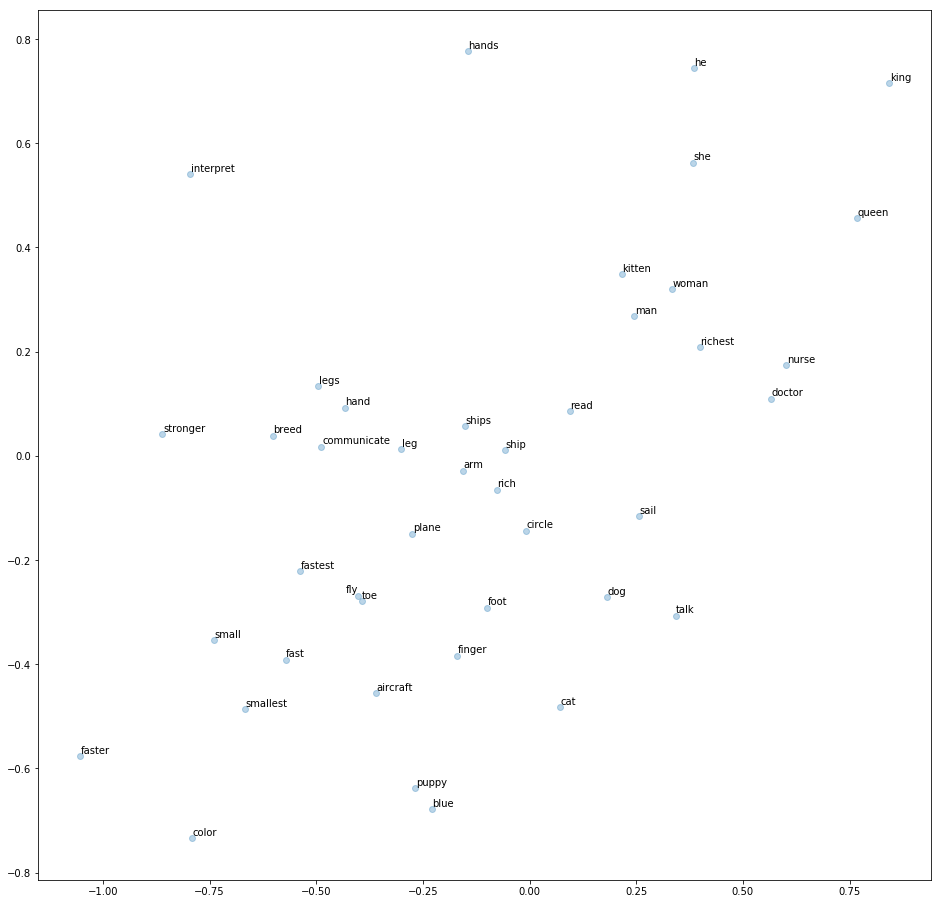

In [26]:
plot_embeddings(embs_pca, sg_batcher.token_to_idx, words, fig_size=(16, 16))

Apply TSNE and visualize results
- Multicore version of TSNE is used for speeding up the process (not from sklearn)

In [47]:
%%time
tsne = TSNE(n_components=2, n_iter=1000, n_jobs=-1)
embs_tsne = tsne.fit_transform(W)

CPU times: user 27min 43s, sys: 10min 38s, total: 38min 21s
Wall time: 4min 54s


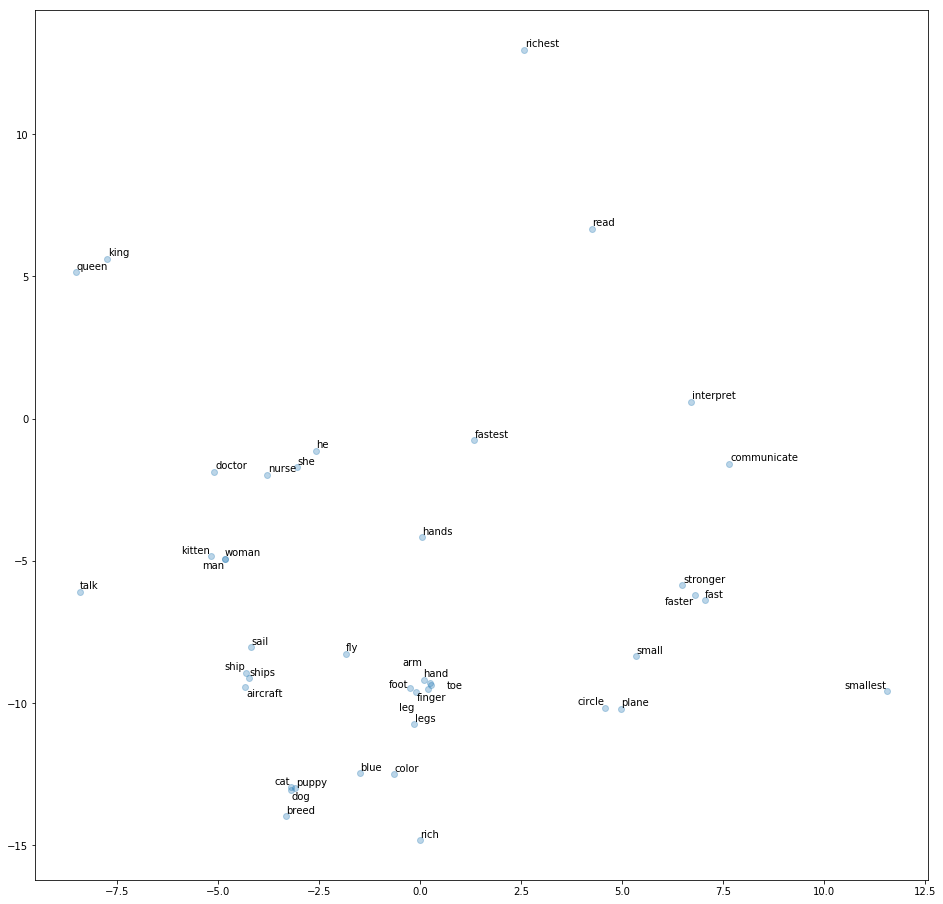

In [48]:
plot_embeddings(embs_tsne, sg_batcher.token_to_idx, words, fig_size=(16, 16))

Apply UMAP and visualize results

In [49]:
%%time
umap = UMAP(metric='euclidean')
embs_umap = umap.fit_transform(W)

CPU times: user 2min 13s, sys: 12.5 s, total: 2min 25s
Wall time: 2min 3s


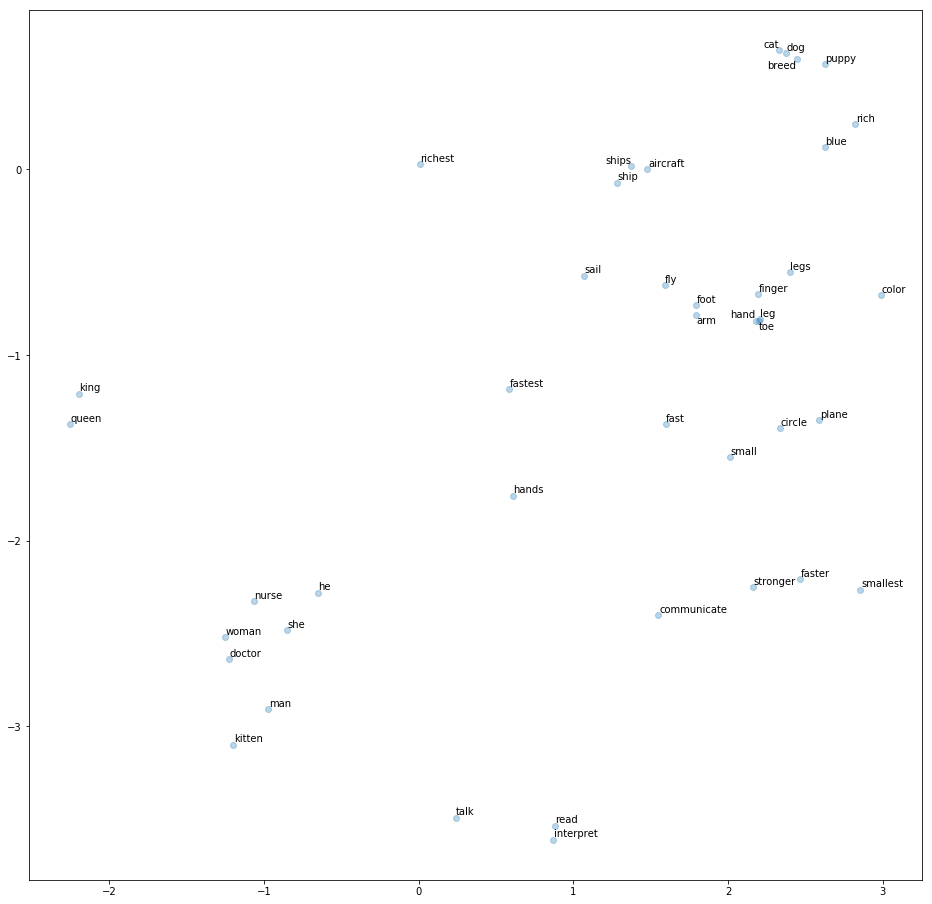

In [50]:
plot_embeddings(embs_umap, sg_batcher.token_to_idx, words, fig_size=(16, 16))

**Conclusion**
- It seems that TSNE and UMAP are better for visualizing relationships among the words (maybe because this algorithms are non-linear and try to preserve distances or topological structure between points)

### Intrinsic evaluation

Create class for exploring neighbors and word analogies

In [27]:
class EmbeddingsExplorer():
    def __init__(self, token_to_idx, vectors, metric='euclidean'):
        self.token_to_idx = token_to_idx
        self.idx_to_token = {idx: token for token, idx 
                             in self.token_to_idx.items()}
        self.vectors = vectors
        self.metric = metric
        
        self.index = AnnoyIndex(vectors.shape[1], metric=metric)
        
        print('Building index is started')
        for i in self.token_to_idx.values():
            self.index.add_item(i, self.vectors[i])
        
        self.index.build(50)
        print('Building index is finished')
        
    def get_embedding(self, token):
        return self.vectors[self.token_to_idx[token]]
    
    def get_closest_to_vector(self, vector, n=1):
        nn_indices = self.index.get_nns_by_vector(vector, n)
        return [self.idx_to_token[neighbor] for neighbor in nn_indices]
    
    def compute_closest_tokens(self, target_token, n=1):
        vector = self.get_embedding(target_token)
        closest_tokens = self.get_closest_to_vector(vector, n=n)
        closest_tokens = [token for token in closest_tokens
                          if token != target_token]
        print(f'{target_token}: {closest_tokens}')
    
    def compute_analogy(self, token1, token2, token3, n=30):
        vec1 = self.get_embedding(token1)
        vec2 = self.get_embedding(token2)
        vec3 = self.get_embedding(token3)
        vec4 = vec3 + vec2 - vec1
        
        tokens = set([token1, token2, token3])
        closest_tokens = self.get_closest_to_vector(vec4, n=n)
        closest_tokens = [token for token in closest_tokens
                          if token not in tokens]
        
        if len(closest_tokens) == 0:
            print('Could not find nearest neighbors for the computed vector')
            return
        
        print(f'{token1}:{token2} :: {token3}:{closest_tokens}')

For evaluation, euclidean metric from Annoy package was used.
I suppose that norm of the vectors is important feature for this task (more details can be found here - https://stats.stackexchange.com/questions/177905/should-i-normalize-word2vecs-word-vectors-before-using-them)  

In [28]:
emb_explorer = EmbeddingsExplorer(sg_batcher.token_to_idx, W, metric='euclidean')
emb_explorer

Building index is started
Building index is finished


**Word Analogies**

In [29]:
emb_explorer.compute_analogy('man', 'he', 'woman')

man:he :: woman:['she', 'secretly', 'admitted', 'met', 'himself', 'arnaz', 'him', 'subsequently', 'later', 'married', 'herself', 'her', 'whom', 'jolie', 'never', 'his', 'recalled', 'said', 'who', 'spoke', 'initially', 'laban', 'marry', 'thereafter', 'mother', 'hanjour', 'attended', 'aisha', 'reportedly']


In [30]:
emb_explorer.compute_analogy('fly', 'plane', 'sail')

fly:plane :: sail:['arc', 'eastward', 'mordor', 'starting', 'departure', 'plotted', 'ship', 'ascent', 'hannibal', 'voyage', 'sun', 'probe', 'rest', 'halley', 'landing', 'marched', 'gondor', 'adriatic', 'nearest', 'charlemagne', 'journey', 'akbar', 'orbit', 'zenith', 'neptune', 'tweed', 'from', 'was']


In [31]:
emb_explorer.compute_analogy('fly', 'aircraft', 'sail')

fly:aircraft :: sail:['ships', 'ship', 'cruise', 'frigates', 'reconnaissance', 'trucks', 'battleship', 'torpedo', 'lockheed', 'locomotive', 'escort', 'submarine', 'naval', 'vehicle', 'raf', 'motorcycles', 'jeep', 'boats', 'cars', 'warship', 'landing', 'guns', 'jets', 'carriers', 'airliners', 'fleet', 'armoured', 'logistics', 'mazda']


In [32]:
emb_explorer.compute_analogy('kitten', 'cat', 'puppy')

kitten:cat :: puppy:['pear', 'goat', 'dog', 'hairless', 'pig', 'peppers', 'greenish', 'hairstyle', 'spruce', 'toad', 'pronounced', 'flap', 'rat', 'ol', 'tailed', 'coeur', 'alveolar', 'acacia', 'ate', 'marjoram', 'bean', 'signifies', 'felis', 'hamster', 'fruit', 'chicken', 'alligator', 'mushroom']


In [33]:
emb_explorer.compute_analogy('cat', 'kitten', 'dog')

cat:kitten :: dog:['dreams', 'treasure', 'entitled', 'teenage', 'sketch', 'honeymoon', 'man', 'titled', 'dragons', 'chariot', 'comedy', 'walks', 'rhino', 'godzilla', 'mess', 'monsters', 'cinderella', 'nessie', 'flock', 'favourite', 'clowns', 'love', 'adventures', 'mad', 'forever', 'puppet', 'hunt', 'thrill', 'sword']


In [34]:
emb_explorer.compute_analogy('blue', 'color', 'dog')

blue:color :: dog:['cat', 'watching', 'nonsensical', 'guess', 'foal', 'unique', 'wherein', 'really', 'means', 'is', 'just', 'similarly', 'ass', 'so', 'dreaming', 'idiot', 'actually', 'instead', 'remember', 'grasp', 'here', 'know', 'conversely', 'cow', 'tags', 'remembering', 'imitate', 'maybe', 'simply', 'little']


In [35]:
emb_explorer.compute_analogy('toe', 'finger', 'foot')

toe:finger :: foot:['ceiling', 'flanked', 'torso', 'bow', 'beneath', 'roof', 'lane', 'pulling', 'bare', 'hanging', 'lined', 'ton', 'painted', 'pot', 'fingers', 'closes', 'grass', 'floor', 'underneath', 'severn', 'neck', 'escarpment', 'flat', 'hand', 'pushes', 'benches', 'mound', 'vine']


In [36]:
emb_explorer.compute_analogy('talk', 'communicate', 'read')

talk:communicate :: read:['communicated', 'commands', 'manipulated', 'freely', 'transcribe', 'execute', 'automatically', 'analyze', 'cannot', 'trusted', 'be', 'correctly', 'translate', 'reliably', 'anonymity', 'simplify', 'assist', 'supplied', 'carefully', 'to', 'manipulate', 'enabled', 'likewise', 'handle', 'copied', 'them', 'instructions', 'easily', 'write']


In [37]:
emb_explorer.compute_analogy('man', 'king', 'woman')

man:king :: woman:['prince', 'queen', 'jeroboam', 'matilda', 'son', 'vii', 'sigismund', 'illegitimate', 'isabella', 'viii', 'andronicus', 'jadwiga', 'bishop', 'tsar', 'elector', 'jehoram', 'elizabeth', 'baldwin', 'duke', 'henry', 'pharaoh', 'heir', 'ferdinand', 'constantine', 'daughter', 'iii', 'empress', 'alfonso', 'honorius']


In [38]:
emb_explorer.compute_analogy('man', 'doctor', 'woman')

man:doctor :: woman:['child', 'young', 'investigator', 'student', 'nurse', 'protagonist', 'doctors', 'heroine', 'astronaut', 'superhero', 'arnaz', 'students', 'tutor', 'detective', 'she', 'prodigy', 'lawyer', 'reviewer', 'uncle', 'fellow', 'juris', 'sweetheart', 'gladiator', 'bride', 'monk', 'kelley', 's', 'companion']


In [39]:
emb_explorer.compute_analogy('woman', 'doctor', 'man')

woman:doctor :: man:['randi', 'master', 'guild', 'science', 'dawn', 'series', 'villain', 'nessie', 'genius', 'pirate', 'ghost', 'magic', 'mystery', 'reading', 'coward', 'sagan', 'companion', 'novel', 'blackadder', 'vampire', 'mad', 'protagonist', 'trek', 'dream', 'robot', 'excalibur', 'salinger', 'character', 'wizard']


In [40]:
emb_explorer.compute_analogy('right', 'left', 'bottom')

right:left :: bottom:['top', 'tip', 'spot', 'fingerboard', 'underneath', 'mound', 'nut', 'upper', 'stays', 'side', 'crosses', 'bow', 'belly', 'tide', 'wall', 'corner', 'mountains', 'winding', 'tops', 'mouth', 'atop', 'inside', 'hills', 'pot', 'finger', 'nile', 'red', 'escarpment', 'moor']


In [41]:
emb_explorer.compute_analogy('leg', 'legs', 'hand')

leg:legs :: hand:['boxes', 'fingers', 'ornaments', 'linen', 'lips', 'buttons', 'them', 'casts', 'boots', 'screens', 'with', 'close', 'sleeves', 'finger', 'beards', 'bars', 'fins', 'suits', 'worn', 'noses', 'balls', 'are', 'brakes', 'bonuses', 'markings', 'faces', 'gems', 'pads']


In [42]:
emb_explorer.compute_analogy('fast', 'fastest', 'small')

fast:fastest :: small:['largest', 'smallest', 'richest', 'vast', 'large', 'biggest', 'populous', 'populated', 'populations', 'farmland', 'areas', 'portion', 'the', 'fertile', 'portions', 'region', 'scattered', 'larger', 'majority', 'communities', 'industry', 'around', 'industrialized', 'residential', 'backbone', 'farms', 'prosperous', 'smaller']


In [43]:
emb_explorer.compute_analogy('large', 'largest', 'old')

large:largest :: old:['oldest', 'busiest', 'norse', 'slavonic', 'minaret', 'rden', 'edda', 'mona', 'third', 'schloss', 'town', 'hou', 'epp', 'limburg', 'taj', 'georgian', 'legnica', 'exeter', 'iliad', 'larissa', 'shaolin', 'episcopal', 'dearborn', 'mesopotamian', 'anglo', 'cologne', 'bratislava', 'wealthiest', 'southernmost']


In [44]:
emb_explorer.compute_analogy('fast', 'faster', 'strong')

fast:faster :: strong:['stronger', 'weaker', 'historically', 'less', 'wielded', 'deeper', 'much', 'fragmented', 'significantly', 'than', 'comparatively', 'greater', 'vastly', 'have', 'larger', 'progressively', 'become', 'has', 'substantially', 'considerably', 'steadily', 'centralized', 'broad', 'very', 'markedly', 'however', 'nonetheless', 'quite']


**Top closest words**

In [45]:
for word in words:
    emb_explorer.compute_closest_tokens(word, n=10)

dog: ['cat', 'rat', 'wolf', 'dogs', 'bear', 'bird', 'haired', 'goat', 'snake']
richest: ['poorest', 'wealthiest', 'oldest', 'cities', 'city', 'town', 'america', 'hubei', 'residing']
blue: ['red', 'yellow', 'white', 'black', 'green', 'purple', 'colored', 'colour', 'bright']
fly: ['pilots', 'dive', 'catch', 'off', 'shoot', 'vessel', 'airplane', 'crew', 'sneak']
ship: ['boat', 'vessel', 'sailing', 'vehicle', 'helicopter', 'carrying', 'fleet', 'warship', 'sail']
he: ['she', 'himself', 'him', 'recalled', 'once', 'had', 'said', 'told', 'again']
hands: ['them', 'face', 'finally', 'pulled', 'guards', 'rested', 'lay', 'thigh', 'fell']
smallest: ['subshell', 'rotation', 'fraction', 'triangulation', 'value', 'dimensions', 'variable', 'reals', 'represented']
communicate: ['to', 'attach', 'interact', 'learn', 'acquire', 'manipulate', 'users', 'simultaneously', 'confuse']
kitten: ['fictional', 'miss', 'hamlet', 'nessie', 'honeymoon', 'recurring', 'teenage', 'strange', 'villains']
doctor: ['young', '

**Conclusion**
- Trained word vectors can capture both several syntactic and semantic relationships, but it seems that this model is a little bit worse on word analogies and nearest neighbors than the model from task 3